# Feature Engineering
## Dataset: Fitness Tracking - Experience Level Classification

---

**Autore:** Alessandro Ambrosio  
**Versione:** 1.0

---

### Obiettivo

Trasformazione dei dati grezzi in feature aggregate e derivate utilizzabili per la modellazione.

Questo notebook implementa le trasformazioni identificate durante l'EDA, creando:
- Aggregazioni statistiche per utente
- Feature derivate (rapporti, coefficienti di variazione, trend)
- Encoding variabili categoriche
- Feature comportamentali (skip rate, consistenza)
- Dataset finale pronto per il training

---

### Struttura del Notebook

1. Setup e Caricamento Dati
2. Aggregazioni Base per Utente
3. Feature Performance (Load, Reps, RPE)
4. Feature Volume e Intensità
5. Feature Comportamentali
6. Feature Consistenza e Variabilità
7. Feature per Esercizio
8. Feature Temporali (Safe)
9. Encoding Variabili Categoriche
10. Merge Feature Set Completo
11. Analisi Feature Finali
12. Salvataggio Dataset Processato

---

### Principi Guida

- **Solo feature osservabili:** Esclusione parametri latenti e piano allenamento
- **No temporal leakage:** Esclusione week_index_user
- **Aggregazione per utente:** Tutte le feature calcolate a livello utente
- **Robustezza:** Gestione missing values e outliers
- **Interpretabilità:** Feature con significato fisico/fisiologico chiaro


---

# SEZIONE 1: Setup e Caricamento Dati

Importazione librerie e caricamento dataset grezzi.

---

In [1]:
# -*- coding: utf-8 -*-
"""
═══════════════════════════════════════════════════════════════════════════
 FEATURE ENGINEERING
 Dataset: Fitness Tracking - Experience Level Classification
═══════════════════════════════════════════════════════════════════════════
"""

import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
warnings.filterwarnings('ignore')

print("="*80)
print("FEATURE ENGINEERING - INIZIALIZZAZIONE")
print("="*80)

# Caricamento dati
print("\nCaricamento dataset...")
df_users = pd.read_csv('users.csv')
df_sets = pd.read_csv('workout_sets.csv')
df_workouts = pd.read_csv('workouts.csv')
df_exercises = pd.read_csv('exercises.csv')

# Pulizia colonne duplicate
df_sets = df_sets.drop(columns=['experience_label'], errors='ignore')
df_workouts = df_workouts.drop(columns=['experience_label'], errors='ignore')

print(f"  - users: {len(df_users)} righe")
print(f"  - workout_sets: {len(df_sets)} righe")
print(f"  - workouts: {len(df_workouts)} righe")
print(f"  - exercises: {len(df_exercises)} righe")

# Merge base per analisi
df_analysis = df_sets.merge(
    df_users[['userid', 'experience_label']],
    on='userid',
    how='left'
)

print(f"\nDataset analisi: {len(df_analysis)} set totali")
print("Setup completato.")


FEATURE ENGINEERING - INIZIALIZZAZIONE

Caricamento dataset...
  - users: 1000 righe
  - workout_sets: 99791 righe
  - workouts: 49446 righe
  - exercises: 12 righe

Dataset analisi: 99791 set totali
Setup completato.


---

# SEZIONE 2: Aggregazioni Base per Utente

Calcolo statistiche descrittive aggregate a livello utente.

**Aggregazioni calcolate:**
- Conteggi: numero totale set, sessioni, esercizi unici
- Durata: intervallo temporale osservazione (giorni)
- Feature dichiarate: frequenza settimanale, split type

**Output:** DataFrame `user_base_features`

---

In [2]:
print("="*80)
print("AGGREGAZIONI BASE PER UTENTE")
print("="*80)

# Conteggi base
user_base = df_analysis.groupby('userid').agg({
    'workoutid': 'nunique',
    'exerciseid': 'nunique',
    'set_index': 'count'
}).reset_index()

user_base.columns = ['userid', 'total_workouts', 'unique_exercises', 'total_sets']

# Durata osservazione (giorni)
workout_dates = df_workouts.groupby('userid')['date'].agg(['min', 'max']).reset_index()
workout_dates['min'] = pd.to_datetime(workout_dates['min'])
workout_dates['max'] = pd.to_datetime(workout_dates['max'])
workout_dates['observation_days'] = (workout_dates['max'] - workout_dates['min']).dt.days + 1

user_base = user_base.merge(
    workout_dates[['userid', 'observation_days']],
    on='userid'
)

# Feature dichiarate (da users.csv)
user_base = user_base.merge(
    df_users[['userid', 'weeklyfreq_declared', 'splittype', 'experience_label']],
    on='userid'
)

# Frequenza osservata (workouts / settimane)
user_base['observed_freq_weekly'] = (
    user_base['total_workouts'] / (user_base['observation_days'] / 7)
).round(2)

print(f"\nFeature base create: {len(user_base.columns) - 2}")  # -2 per userid e target
print(f"Utenti processati: {len(user_base)}")
print("\nPrime 5 righe:")
print(user_base.head().to_string())


AGGREGAZIONI BASE PER UTENTE

Feature base create: 7
Utenti processati: 174

Prime 5 righe:
   userid  total_workouts  unique_exercises  total_sets  observation_days  weeklyfreq_declared splittype experience_label  observed_freq_weekly
0       1              11                10         174                23                    4       PPL         Beginner                  3.35
1       2              36                 8         480               143                    2  FullBody     Intermediate                  1.76
2       3              99                 9        1920               223                    4  FullBody     Intermediate                  3.11
3       4               8                 7         120                28                    2  FullBody     Intermediate                  2.00
4       5              11                11         203                23                    5       PPL     Intermediate                  3.35


---

# SEZIONE 3: Feature Performance (Load, Reps, RPE)

Aggregazioni statistiche sulle variabili di performance fisica.

**Feature calcolate:**

**Load (kg):**
- `load_mean`: Carico medio sollevato
- `load_max`: Carico massimo osservato
- `load_std`: Deviazione standard carico
- `load_median`: Carico mediano

**Reps:**
- `reps_mean`: Ripetizioni medie per set
- `reps_total`: Volume totale ripetizioni
- `reps_std`: Variabilità ripetizioni

**RPE (Rating of Perceived Exertion):**
- `rpe_mean`: RPE medio (intensità percepita)
- `rpe_std`: Variabilità RPE
- `rpe_max`: RPE massimo osservato

**Output:** DataFrame `user_performance_features`

---

In [3]:
print("="*80)
print("FEATURE PERFORMANCE")
print("="*80)

# Aggregazioni performance
user_performance = df_analysis.groupby('userid').agg({
    'load_done_kg': ['mean', 'max', 'std', 'median'],
    'reps_done': ['mean', 'sum', 'std'],
    'rpe_done': ['mean', 'std', 'max']
}).reset_index()

# Flatten colonne multi-index
user_performance.columns = [
    'userid',
    'load_mean', 'load_max', 'load_std', 'load_median',
    'reps_mean', 'reps_total', 'reps_std',
    'rpe_mean', 'rpe_std', 'rpe_max'
]

# Gestione NaN per std (utenti con 1 solo set)
user_performance['load_std'] = user_performance['load_std'].fillna(0)
user_performance['reps_std'] = user_performance['reps_std'].fillna(0)
user_performance['rpe_std'] = user_performance['rpe_std'].fillna(0)

print(f"\nFeature performance create: {len(user_performance.columns) - 1}")
print(f"\nStatistiche descrittive:")
print(user_performance.describe().round(2).to_string())


FEATURE PERFORMANCE

Feature performance create: 10

Statistiche descrittive:
       userid  load_mean  load_max  load_std  load_median  reps_mean  reps_total  reps_std  rpe_mean  rpe_std  rpe_max
count  174.00     174.00    174.00    174.00       174.00     174.00      174.00    174.00    174.00   174.00   174.00
mean    87.91      41.73     66.33      8.86        41.02       9.16     5237.70      3.56      4.43     0.62     6.23
std     50.79      12.74     22.26      3.16        12.55       0.57     4125.08      0.22      0.35     0.08     0.49
min      1.00      23.54     33.50      3.64        22.00       8.17      548.00      2.70      3.56     0.44     4.50
25%     44.25      28.05     45.25      6.34        27.50       8.83     1688.50      3.42      4.19     0.57     6.00
50%     87.50      43.74     65.75      8.38        43.19       9.06     4376.00      3.55      4.44     0.62     6.00
75%    131.75      48.61     79.62     10.79        47.75       9.41     7423.25      3.7

---

# SEZIONE 4: Feature Volume e Intensità

Calcolo metriche di volume e intensità dell'allenamento.

**Feature derivate:**

**Volume:**
- `total_volume`: sets × reps_mean (volume totale)
- `volume_per_workout`: volume / numero_sessioni
- `sets_per_workout`: set medi per sessione

**Intensità:**
- `load_volume_product`: load_mean × reps_total (tonnellaggio)
- `intensity_score`: rpe_mean × load_mean (intensità percepita ponderata)
- `relative_intensity`: load_mean / load_max (percentuale carico massimale)

**Output:** DataFrame `user_volume_features`

---

In [4]:
print("="*80)
print("FEATURE VOLUME E INTENSITA'")
print("="*80)

# Merge base + performance per calcoli derivati
user_volume = user_base[['userid', 'total_sets', 'total_workouts']].merge(
    user_performance[['userid', 'load_mean', 'load_max', 'reps_mean', 'reps_total', 'rpe_mean']],
    on='userid'
)

# Volume features
user_volume['total_volume'] = user_volume['total_sets'] * user_volume['reps_mean']
user_volume['volume_per_workout'] = (
    user_volume['total_volume'] / user_volume['total_workouts']
).round(2)
user_volume['sets_per_workout'] = (
    user_volume['total_sets'] / user_volume['total_workouts']
).round(2)

# Intensità features
user_volume['load_volume_product'] = (
    user_volume['load_mean'] * user_volume['reps_total']
).round(2)
user_volume['intensity_score'] = (
    user_volume['rpe_mean'] * user_volume['load_mean']
).round(2)
user_volume['relative_intensity'] = (
    user_volume['load_mean'] / user_volume['load_max']
).round(3)

# Gestione divisioni per zero
user_volume['relative_intensity'] = user_volume['relative_intensity'].fillna(0)

# Keep only derived features
user_volume = user_volume[[
    'userid', 'total_volume', 'volume_per_workout', 'sets_per_workout',
    'load_volume_product', 'intensity_score', 'relative_intensity'
]]

print(f"\nFeature volume/intensità create: {len(user_volume.columns) - 1}")
print(f"\nPrime 5 righe:")
print(user_volume.head().to_string())


FEATURE VOLUME E INTENSITA'

Feature volume/intensità create: 6

Prime 5 righe:
   userid  total_volume  volume_per_workout  sets_per_workout  load_volume_product  intensity_score  relative_intensity
0       1        1656.0              150.55             15.82             44252.53           113.11               0.703
1       2        4366.0              121.28             13.33            206908.92           217.06               0.622
2       3       16651.0              168.19             19.39            917291.85           273.37               0.609
3       4        1158.0              144.75             15.00             51902.52           181.34               0.726
4       5        1916.0              174.18             18.45             81719.30           164.83               0.664


---

# SEZIONE 5: Feature Comportamentali

Analisi del comportamento di aderenza e consistenza dell'utente.

**Feature calcolate:**

**Aderenza:**
- `skip_rate`: Percentuale sessioni saltate (skipped / totale)
- `completion_rate`: Percentuale sessioni completate (done / totale)
- `adherence_score`: 1 - skip_rate (score aderenza 0-1)

**Frequenza:**
- `freq_gap`: weekly_freq_declared - observed_freq_weekly (scostamento dichiarato vs osservato)
- `freq_consistency`: 1 - |freq_gap| / weekly_freq_declared (consistenza frequenza)

**Output:** DataFrame `user_behavioral_features`

---

In [5]:
print("="*80)
print("FEATURE COMPORTAMENTALI")
print("="*80)

# FIX: Metodo corretto per contare status
skip_stats = df_workouts.groupby('userid')['workout_status'].value_counts().unstack(fill_value=0).reset_index()

# Rinomina colonne se esistono
if 'done' in skip_stats.columns:
    skip_stats = skip_stats.rename(columns={'done': 'done_sessions'})
if 'skipped' in skip_stats.columns:
    skip_stats = skip_stats.rename(columns={'skipped': 'skipped_sessions'})

# Assicura che le colonne esistano
if 'done_sessions' not in skip_stats.columns:
    skip_stats['done_sessions'] = 0
if 'skipped_sessions' not in skip_stats.columns:
    skip_stats['skipped_sessions'] = 0

skip_stats['total_sessions'] = skip_stats['done_sessions'] + skip_stats['skipped_sessions']
skip_stats['skip_rate'] = (skip_stats['skipped_sessions'] / skip_stats['total_sessions'] * 100).round(2)
skip_stats['completion_rate'] = (skip_stats['done_sessions'] / skip_stats['total_sessions'] * 100).round(2)
skip_stats['adherence_score'] = (1 - skip_stats['skip_rate'] / 100).round(3)

user_behavioral = skip_stats.merge(
    user_base[['userid', 'weeklyfreq_declared', 'observed_freq_weekly']], on='userid'
)

user_behavioral['freq_gap'] = (user_behavioral['weeklyfreq_declared'] - user_behavioral['observed_freq_weekly']).round(2)
user_behavioral['freq_consistency'] = (1 - user_behavioral['freq_gap'].abs() / user_behavioral['weeklyfreq_declared']).clip(0, 1).round(3)

user_behavioral = user_behavioral[['userid', 'skip_rate', 'completion_rate', 'adherence_score', 'freq_gap', 'freq_consistency']]

print(f"\nFeature comportamentali create: {len(user_behavioral.columns) - 1}")
print(f"\nDistribuzione skip_rate per livello:")

# Merge con target per analisi
behavioral_analysis = user_behavioral.merge(
    df_users[['userid', 'experience_label']],
    on='userid'
)
print(behavioral_analysis.groupby('experience_label')['skip_rate'].describe().round(2).to_string())

FEATURE COMPORTAMENTALI

Feature comportamentali create: 5

Distribuzione skip_rate per livello:
                  count  mean   std  min   25%    50%    75%    max
experience_label                                                   
Advanced           20.0   9.3  6.58  0.0  4.99   8.33  11.70  28.57
Beginner           60.0  14.4  7.50  0.0  9.27  15.00  18.30  31.51
Intermediate       94.0  10.3  6.48  0.0  6.65   9.92  13.75  40.00


---

# SEZIONE 6: Feature Consistenza e Variabilità

Metriche di consistenza e variabilità della performance.

**Feature calcolate:**

**Coefficienti di Variazione (CV):**
- `cv_load`: load_std / load_mean (consistenza carico)
- `cv_reps`: reps_std / reps_mean (consistenza ripetizioni)
- `cv_rpe`: rpe_std / rpe_mean (consistenza percezione sforzo)

**Range Features:**
- `load_range_pct`: (load_max - load_median) / load_max (range carico percentuale)

**Interpretazione CV:**
- CV < 0.15: Consistenza ALTA
- 0.15 ≤ CV < 0.30: Consistenza MEDIA
- CV ≥ 0.30: Consistenza BASSA (alta variabilità)

**Output:** DataFrame `user_consistency_features`

---

In [6]:
print("="*80)
print("FEATURE CONSISTENZA E VARIABILITA'")
print("="*80)

# Merge performance features per calcoli CV
user_consistency = user_performance[[
    'userid', 'load_mean', 'load_std', 'load_max', 'load_median',
    'reps_mean', 'reps_std', 'rpe_mean', 'rpe_std'
]].copy()

# Coefficienti di variazione
user_consistency['cv_load'] = (
    user_consistency['load_std'] / user_consistency['load_mean']
).round(3)
user_consistency['cv_reps'] = (
    user_consistency['reps_std'] / user_consistency['reps_mean']
).round(3)
user_consistency['cv_rpe'] = (
    user_consistency['rpe_std'] / user_consistency['rpe_mean']
).round(3)

# Gestione divisioni per zero e infiniti
user_consistency['cv_load'] = user_consistency['cv_load'].replace([np.inf, -np.inf], np.nan).fillna(0)
user_consistency['cv_reps'] = user_consistency['cv_reps'].replace([np.inf, -np.inf], np.nan).fillna(0)
user_consistency['cv_rpe'] = user_consistency['cv_rpe'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Range percentuale load
user_consistency['load_range_pct'] = (
    (user_consistency['load_max'] - user_consistency['load_median']) / user_consistency['load_max'] * 100
).round(2)
user_consistency['load_range_pct'] = user_consistency['load_range_pct'].fillna(0)

# Keep only derived features
user_consistency = user_consistency[[
    'userid', 'cv_load', 'cv_reps', 'cv_rpe', 'load_range_pct'
]]

print(f"\nFeature consistenza create: {len(user_consistency.columns) - 1}")
print(f"\nStatistiche CV:")
print(user_consistency[['cv_load', 'cv_reps', 'cv_rpe']].describe().round(3).to_string())


FEATURE CONSISTENZA E VARIABILITA'

Feature consistenza create: 4

Statistiche CV:
       cv_load  cv_reps   cv_rpe
count  174.000  174.000  174.000
mean     0.212    0.390    0.142
std      0.034    0.034    0.021
min      0.139    0.231    0.096
25%      0.187    0.371    0.128
50%      0.213    0.392    0.140
75%      0.235    0.412    0.154
max      0.373    0.491    0.204


---

# SEZIONE 7: Feature per Tipo Esercizio

Aggregazioni stratificate per categoria di esercizio.

**Approccio:**
- Identificazione esercizi compound principali (Squat, Deadlift, Bench Press)
- Calcolo carico medio per esercizio
- Pivot per creare feature separate per esercizio

**Feature create:**
- `load_squat`: Carico medio Squat
- `load_deadlift`: Carico medio Deadlift
- `load_bench`: Carico medio Bench Press
- `load_overhead`: Carico medio Overhead Press
- `has_compound`: Flag presenza esercizi compound (1/0)

**Razionale:**  
Gli esercizi compound sono forti indicatori di livello tecnico e forza.

**Output:** DataFrame `user_exercise_features`

---

In [7]:
print("="*80)
print("FEATURE PER TIPO ESERCIZIO")
print("="*80)

# Merge con catalogo esercizi per nomi
df_ex_analysis = df_analysis.merge(
    df_exercises[['exerciseid', 'name']],
    left_on='exerciseid',
    right_on='exerciseid',
    how='left'
)

# Carico medio per esercizio per utente
exercise_pivot = df_ex_analysis.pivot_table(
    values='load_done_kg',
    index='userid',
    columns='name',
    aggfunc='mean'
).reset_index()

# Rinomina colonne con prefisso
exercise_cols = [col for col in exercise_pivot.columns if col != 'userid']
exercise_pivot.columns = ['userid'] + [f'load_{col.lower().replace(" ", "_")}' for col in exercise_cols]

# Flag presenza esercizi compound
compound_exercises = ['load_squat', 'load_deadlift', 'load_bench_press']
has_compound = exercise_pivot[['userid']].copy()
has_compound['has_compound'] = 0

for ex in compound_exercises:
    if ex in exercise_pivot.columns:
        has_compound['has_compound'] += exercise_pivot[ex].notna().astype(int)

has_compound['has_compound'] = (has_compound['has_compound'] >= 2).astype(int)

# Merge flag
user_exercise = exercise_pivot.merge(has_compound, on='userid')

# Fill NaN con 0 (utente non ha fatto quell'esercizio)
user_exercise = user_exercise.fillna(0)

print(f"\nFeature esercizi create: {len(user_exercise.columns) - 1}")
print(f"\nEsercizi presenti nel dataset:")
print([col.replace('load_', '') for col in user_exercise.columns if col.startswith('load_')])
print(f"\nUtenti con esercizi compound: {has_compound['has_compound'].sum()} / {len(has_compound)}")


FEATURE PER TIPO ESERCIZIO

Feature esercizi create: 13

Esercizi presenti nel dataset:
['barbell_row', 'bench_press', 'cable_fly', 'incline_db_press', 'lat_pulldown', 'lateral_raise', 'leg_curl', 'leg_press', 'plank', 'romanian_deadlift', 'seated_cable_row', 'squat']

Utenti con esercizi compound: 129 / 174


---

# SEZIONE 8: Feature Temporali (Safe - No Leakage)

Feature temporali calcolate senza introdurre temporal leakage.

**Approccio sicuro:**
- **NO week_index_user** (correlato artificialmente con livello)
- **SI observation_days** (già calcolato in sezione 2)
- **SI giorni tra sessioni** (media, variabilità)

**Feature calcolate:**
- `avg_days_between_workouts`: Media giorni tra sessioni consecutive
- `std_days_between_workouts`: Variabilità spaziatura sessioni
- `consistency_temporal`: 1 / (1 + std_days) (consistenza temporale)

**Razionale:**  
La regolarità temporale (non la durata assoluta) è indicativa di livello.

**Output:** DataFrame `user_temporal_features`

---

In [8]:
print("="*80)
print("FEATURE TEMPORALI (SAFE)")
print("="*80)

# Prepara date per calcolo intervalli
df_workouts_sorted = df_workouts[df_workouts['workout_status'] == 'done'].copy()
df_workouts_sorted['date'] = pd.to_datetime(df_workouts_sorted['date'])
df_workouts_sorted = df_workouts_sorted.sort_values(['userid', 'date'])

# Calcola giorni tra sessioni consecutive
df_workouts_sorted['days_since_last'] = df_workouts_sorted.groupby('userid')['date'].diff().dt.days

# Aggregazioni per utente
temporal_stats = df_workouts_sorted.groupby('userid')['days_since_last'].agg([
    'mean', 'std', 'min', 'max'
]).reset_index()

temporal_stats.columns = ['userid', 'avg_days_between_workouts',
                          'std_days_between_workouts', 'min_days_gap', 'max_days_gap']

# Gestione NaN (utenti con 1 sola sessione)
temporal_stats = temporal_stats.fillna(0)

# Consistenza temporale (più basso std = più consistente)
temporal_stats['consistency_temporal'] = (
    1 / (1 + temporal_stats['std_days_between_workouts'])
).round(3)

user_temporal = temporal_stats[[
    'userid', 'avg_days_between_workouts', 'std_days_between_workouts', 'consistency_temporal'
]]

# Round per leggibilità
user_temporal['avg_days_between_workouts'] = user_temporal['avg_days_between_workouts'].round(2)
user_temporal['std_days_between_workouts'] = user_temporal['std_days_between_workouts'].round(2)

print(f"\nFeature temporali create: {len(user_temporal.columns) - 1}")
print(f"\nStatistiche:")
print(user_temporal.describe().round(2).to_string())

print("\nNOTA: week_index_user escluso per evitare temporal leakage.")


FEATURE TEMPORALI (SAFE)

Feature temporali create: 3

Statistiche:
        userid  avg_days_between_workouts  std_days_between_workouts  consistency_temporal
count   991.00                     991.00                     991.00                991.00
mean    499.45                       2.69                       1.47                  0.42
std     288.67                       1.01                       0.55                  0.09
min       1.00                       1.36                       0.41                  0.20
25%     249.50                       2.09                       1.07                  0.37
50%     499.00                       2.46                       1.34                  0.43
75%     748.50                       2.92                       1.73                  0.48
max    1000.00                       9.12                       4.14                  0.71

NOTA: week_index_user escluso per evitare temporal leakage.


---

# SEZIONE 9: Encoding Variabili Categoriche

Trasformazione variabili categoriche in formato numerico.

**Variabili da encodare:**

**split_type:**
- Tipo split allenamento (PPL, Upper/Lower, Full Body)
- Metodo: One-Hot Encoding

**experience_label (target):**
- Beginner → 0
- Intermediate → 1
- Advanced → 2
- Metodo: Ordinal Encoding (preserva ordine naturale)

**Note:**
- exercise_id già gestito in sezione 7 (feature per esercizio)
- session_tag (Push/Pull/Legs) già implicito in split_type

**Output:** DataFrame `user_categorical_encoded`

---

In [9]:
print("="*80)
print("ENCODING VARIABILI CATEGORICHE")
print("="*80)

# One-Hot Encoding split_type
split_encoded = pd.get_dummies(
    df_users[['userid', 'splittype']],
    columns=['splittype'],
    prefix='split'
)

print(f"\nSplit types identificati:")
split_cols = [col for col in split_encoded.columns if col.startswith('split_')]
print(split_cols)

# Ordinal Encoding target
target_mapping = {
    'Beginner': 0,
    'Intermediate': 1,
    'Advanced': 2
}

user_target = df_users[['userid', 'experience_label']].copy()
user_target['target_encoded'] = user_target['experience_label'].map(target_mapping)

# Merge encoding
user_categorical = split_encoded.merge(user_target, on='userid')

print(f"\nDistribuzione target:")
print(user_target['experience_label'].value_counts().to_string())
print(f"\nEncoding completato: {len(user_categorical.columns) - 1} feature create")


ENCODING VARIABILI CATEGORICHE

Split types identificati:
['split_FullBody', 'split_PPL']

Distribuzione target:
experience_label
Intermediate    540
Beginner        347
Advanced        113

Encoding completato: 4 feature create


---

# SEZIONE 10: Merge Feature Set Completo

Unificazione di tutti i feature set creati nelle sezioni precedenti.

**Dataset da mergere:**
1. `user_base_features` (sezione 2)
2. `user_performance_features` (sezione 3)
3. `user_volume_features` (sezione 4)
4. `user_behavioral_features` (sezione 5)
5. `user_consistency_features` (sezione 6)
6. `user_exercise_features` (sezione 7)
7. `user_temporal_features` (sezione 8)
8. `user_categorical_encoded` (sezione 9)

**Merge strategy:**
- Join type: INNER (mantiene solo utenti presenti in tutti i dataset)
- Key: `userid`

**Output:** DataFrame `dataset_final`

---

In [10]:
print("="*80)
print("MERGE FEATURE SET COMPLETO")
print("="*80)

# Lista dataset da mergere
datasets_to_merge = [
    ('user_base', user_base),
    ('user_performance', user_performance),
    ('user_volume', user_volume),
    ('user_behavioral', user_behavioral),
    ('user_consistency', user_consistency),
    ('user_exercise', user_exercise),
    ('user_temporal', user_temporal),
    ('user_categorical', user_categorical)
]

# FIX: Rimuovi experience_label da user_base per evitare duplicati
user_base_clean = user_base.drop(columns=['experience_label', 'splittype'], errors='ignore')

# Merge sequenziale
dataset_final = user_base_clean.copy()
print(f"\nPartenza: user_base_clean - {len(dataset_final)} righe, {len(dataset_final.columns)} colonne")


for name, df in datasets_to_merge[1:]:
    before_cols = len(dataset_final.columns)
    dataset_final = dataset_final.merge(df, on='userid', how='inner')
    added_cols = len(dataset_final.columns) - before_cols
    print(f"Merge {name}: +{added_cols} colonne (totale: {len(dataset_final.columns)})")

print(f"\n{'='*80}")
print(f"DATASET FINALE CREATO")
print(f"{'='*80}")
print(f"Righe (utenti): {len(dataset_final)}")
print(f"Colonne totali: {len(dataset_final.columns)}")
print(f"  - userid: 1")
print(f"  - experience_label: 1")
print(f"  - target_encoded: 1")
print(f"  - feature: {len(dataset_final.columns) - 3}")

# Verifica missing values
missing_total = dataset_final.isna().sum().sum()
print(f"\nMissing values totali: {missing_total}")

if missing_total > 0:
    print("\nColonne con missing:")
    missing_cols = dataset_final.isna().sum()
    print(missing_cols[missing_cols > 0].to_string())


MERGE FEATURE SET COMPLETO

Partenza: user_base_clean - 174 righe, 7 colonne
Merge user_performance: +10 colonne (totale: 17)
Merge user_volume: +6 colonne (totale: 23)
Merge user_behavioral: +5 colonne (totale: 28)
Merge user_consistency: +4 colonne (totale: 32)
Merge user_exercise: +13 colonne (totale: 45)
Merge user_temporal: +3 colonne (totale: 48)
Merge user_categorical: +4 colonne (totale: 52)

DATASET FINALE CREATO
Righe (utenti): 174
Colonne totali: 52
  - userid: 1
  - experience_label: 1
  - target_encoded: 1
  - feature: 49

Missing values totali: 0


---

# SEZIONE 11: Analisi Feature Finali

Ispezione e validazione del dataset processato.

**Verifiche effettuate:**
1. Dimensioni dataset
2. Tipi di dato
3. Statistiche descrittive
4. Distribuzione target
5. Correlazioni top feature vs target

**Obiettivo:**  
Validare che tutte le trasformazioni siano corrette prima del salvataggio.

---

In [11]:
print("="*80)
print("ANALISI FEATURE FINALI")
print("="*80)

# 1. Info dataset
print("\n1. INFORMAZIONI DATASET")
print("-" * 80)
print(f"Shape: {dataset_final.shape}")
print(f"Memory usage: {dataset_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 2. Tipi di dato
print("\n2. TIPI DI DATO")
print("-" * 80)
dtype_counts = dataset_final.dtypes.value_counts()
print(dtype_counts.to_string())

# 3. Statistiche descrittive (sample)
print("\n3. STATISTICHE DESCRITTIVE (prime 10 feature numeriche)")
print("-" * 80)
numeric_cols = dataset_final.select_dtypes(include=[np.number]).columns[:10]
print(dataset_final[numeric_cols].describe().round(2).to_string())

# 4. Distribuzione target
print("\n4. DISTRIBUZIONE TARGET")
print("-" * 80)

# FIX: Gestione robusta della colonna target
if 'experience_label' in dataset_final.columns:
    target_dist = dataset_final['experience_label'].value_counts().sort_index()
    target_pct = (target_dist / len(dataset_final) * 100).round(1)
    target_summary = pd.DataFrame({
        'Livello': target_dist.index,
        'Count': target_dist.values,
        'Percentuale': target_pct.values
    })
    print(target_summary.to_string(index=False))
else:
    print("ERROR: experience_label non trovato!")
    print("Colonne disponibili:", list(dataset_final.columns))


# 5. Top correlazioni con target
print("\n5. TOP 15 CORRELAZIONI CON TARGET")
print("-" * 80)
numeric_features = dataset_final.select_dtypes(include=[np.number]).drop(
    columns=['userid', 'target_encoded'], errors='ignore'
)
correlations = numeric_features.corrwith(dataset_final['target_encoded']).sort_values(
    ascending=False, key=abs
).head(15)
print(correlations.round(3).to_string())

print("\n" + "="*80)
print("ANALISI COMPLETATA")
print("="*80)


ANALISI FEATURE FINALI

1. INFORMAZIONI DATASET
--------------------------------------------------------------------------------
Shape: (174, 52)
Memory usage: 0.08 MB

2. TIPI DI DATO
--------------------------------------------------------------------------------
float64    41
int64       8
bool        2
object      1

3. STATISTICHE DESCRITTIVE (prime 10 feature numeriche)
--------------------------------------------------------------------------------
       userid  total_workouts  unique_exercises  total_sets  observation_days  weeklyfreq_declared  observed_freq_weekly  load_mean  load_max  load_std
count  174.00          174.00            174.00      174.00            174.00               174.00                174.00     174.00    174.00    174.00
mean    87.91           43.36              9.59      573.51            106.45                 3.59                  2.89      41.73     66.33      8.86
std     50.79           33.80              1.49      456.00             77.47       

---

# SEZIONE 11b: Distribuzione Feature per Livello

Analisi della distribuzione delle feature principali stratificate per livello di esperienza.

**Obiettivo:**  
Verificare la separabilità delle classi attraverso le feature create.

---


DISTRIBUZIONE FEATURE PER LIVELLO

Statistiche per livello (feature chiave):


LOAD_MEAN:
                   mean   std    min    max
experience_label                           
Advanced          65.11  3.86  59.37  74.72
Beginner          26.95  1.71  23.54  30.75
Intermediate      46.19  4.29  37.54  60.78

REPS_TOTAL:
                     mean      std    min      max
experience_label                                  
Advanced          5751.70  4151.10  548.0  15048.0
Beginner          4600.60  3223.54  569.0  13575.0
Intermediate      5534.99  4597.09  717.0  22543.0

RPE_MEAN:
                  mean   std   min   max
experience_label                        
Advanced          4.45  0.36  3.56  5.07
Beginner          4.38  0.38  3.64  5.57
Intermediate      4.46  0.33  3.59  5.16

TOTAL_VOLUME:
                     mean      std    min      max
experience_label                                  
Advanced          5751.70  4151.10  548.0  15048.0
Beginner          4600.60  3223.54  56

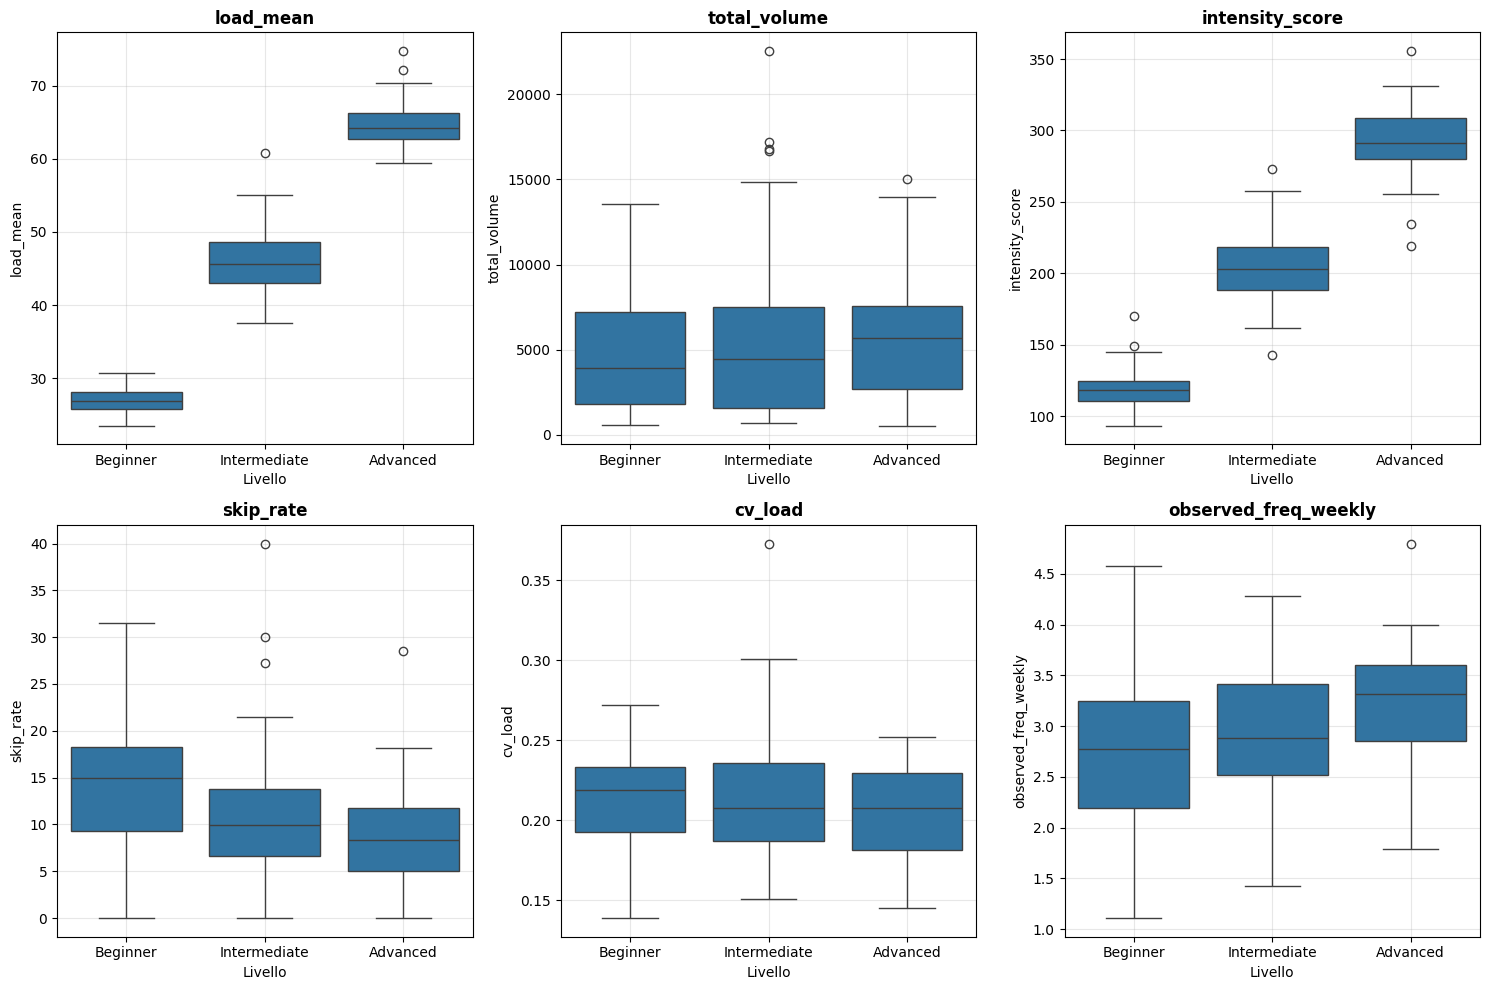

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("DISTRIBUZIONE FEATURE PER LIVELLO")
print("="*80)

# Statistiche descrittive per livello
key_features = ['load_mean', 'reps_total', 'rpe_mean', 'total_volume',
                'intensity_score', 'skip_rate', 'adherence_score']

print("\nStatistiche per livello (feature chiave):\n")
for feature in key_features:
    if feature in dataset_final.columns:
        print(f"\n{feature.upper()}:")
        stats = dataset_final.groupby('experience_label')[feature].describe()[['mean', 'std', 'min', 'max']]
        print(stats.round(2).to_string())

# Visualizzazione boxplot per top feature
print("\nGenerazione boxplot...")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

plot_features = ['load_mean', 'total_volume', 'intensity_score',
                 'skip_rate', 'cv_load', 'observed_freq_weekly']

for idx, feature in enumerate(plot_features):
    if feature in dataset_final.columns:
        sns.boxplot(data=dataset_final, x='experience_label', y=feature, ax=axes[idx])
        axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Livello', fontsize=10)
        axes[idx].set_ylabel(feature, fontsize=10)
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distribution_by_level.png', dpi=150, bbox_inches='tight')
print("Salvato: feature_distribution_by_level.png")
plt.show()


---

# SEZIONE 11c: Matrice Correlazioni Feature

Heatmap delle correlazioni tra feature per identificare ridondanze e multicollinearità.

**Obiettivo:**  
- Identificare feature altamente correlate (|r| > 0.8) da rimuovere  
- Verificare pattern di correlazione tra gruppi di feature  

---


MATRICE CORRELAZIONI

Top 20 feature per correlazione con target:
load_mean                    0.961
load_median                  0.957
intensity_score              0.931
load_max                     0.860
load_std                     0.778
load_seated_cable_row        0.691
load_lat_pulldown            0.622
load_incline_db_press        0.591
load_squat                   0.578
rpe_std                     -0.576
load_cable_fly               0.571
load_leg_curl                0.529
cv_rpe                      -0.525
load_leg_press               0.495
load_barbell_row             0.493
load_bench_press             0.483
load_romanian_deadlift       0.448
load_lateral_raise           0.410
load_volume_product          0.373
std_days_between_workouts   -0.299

Generazione heatmap correlazioni...
Salvato: correlation_matrix_top20.png


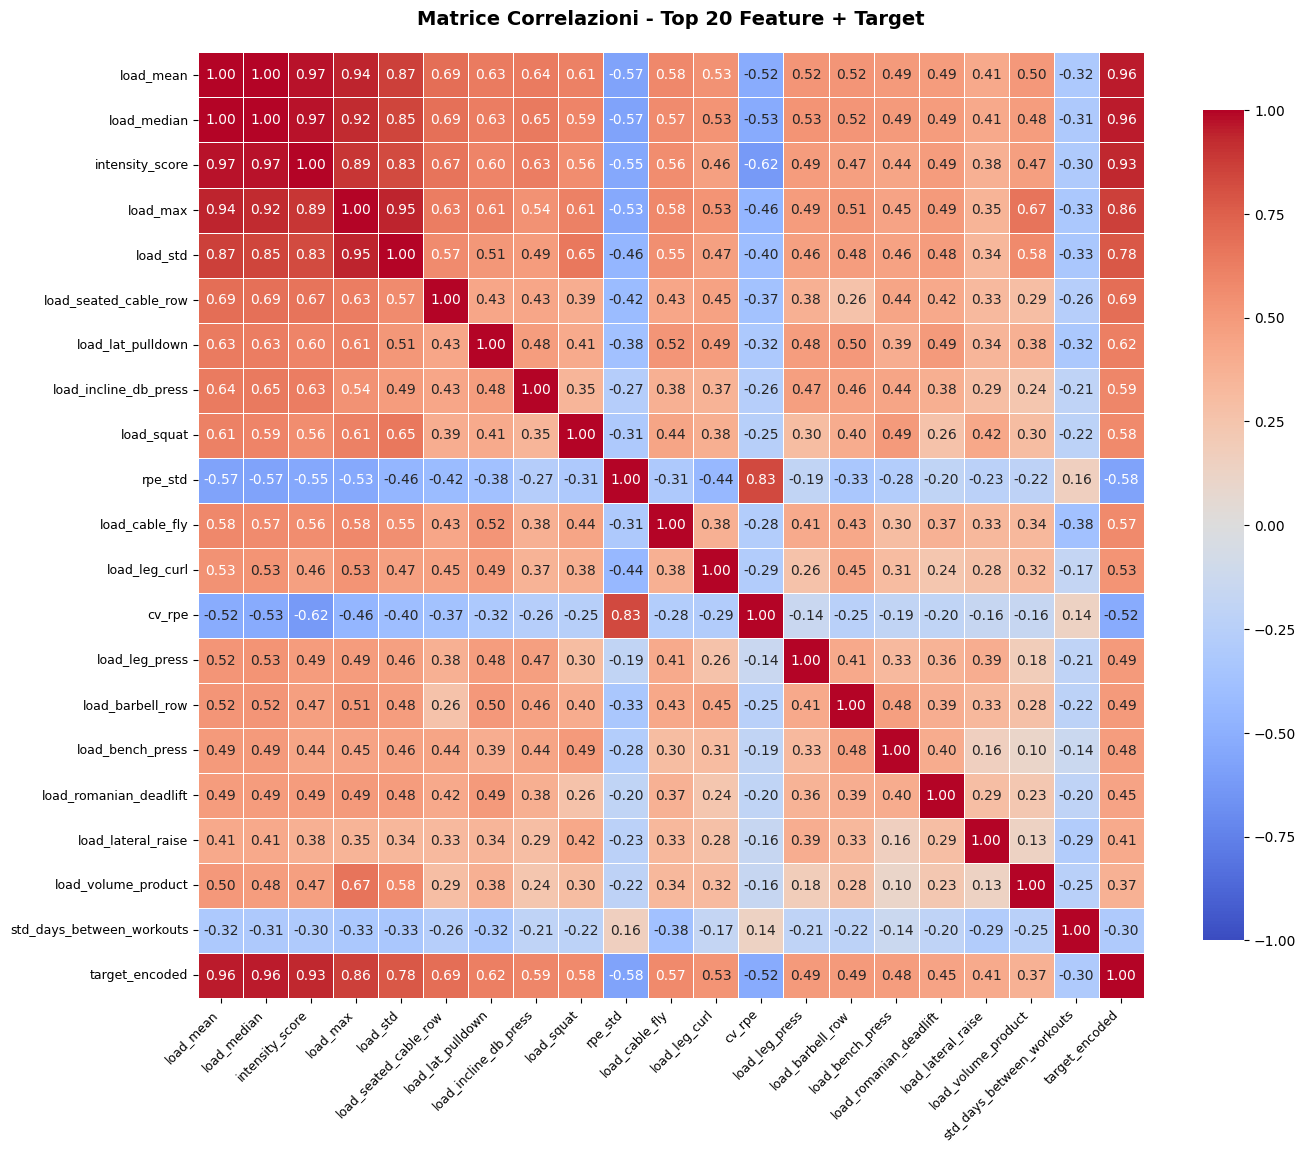


Coppie feature con |r| > 0.8 (multicollinearità):
  - load_mean <-> load_median: 0.995
  - load_mean <-> intensity_score: 0.969
  - load_mean <-> load_max: 0.940
  - load_mean <-> load_std: 0.867
  - load_mean <-> target_encoded: 0.961
  - load_median <-> intensity_score: 0.969
  - load_median <-> load_max: 0.922
  - load_median <-> load_std: 0.847
  - load_median <-> target_encoded: 0.957
  - intensity_score <-> load_max: 0.894
  - intensity_score <-> load_std: 0.825
  - intensity_score <-> target_encoded: 0.931
  - load_max <-> load_std: 0.945
  - load_max <-> target_encoded: 0.860
  - rpe_std <-> cv_rpe: 0.831


In [13]:
print("="*80)
print("MATRICE CORRELAZIONI")
print("="*80)

# Seleziona top 20 feature più correlate con target
numeric_features = dataset_final.select_dtypes(include=[np.number]).drop(
    columns=['userid', 'target_encoded'], errors='ignore'
)

correlations_full = numeric_features.corrwith(dataset_final['target_encoded']).sort_values(
    ascending=False, key=abs
)

top_features = correlations_full.head(20).index.tolist()
print(f"\nTop 20 feature per correlazione con target:")
print(correlations_full.head(20).round(3).to_string())

# Heatmap correlazioni tra top feature
print("\nGenerazione heatmap correlazioni...")
corr_matrix = dataset_final[top_features + ['target_encoded']].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matrice Correlazioni - Top 20 Feature + Target', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig('correlation_matrix_top20.png', dpi=150, bbox_inches='tight')
print("Salvato: correlation_matrix_top20.png")
plt.show()

# Identifica coppie altamente correlate (potenziale multicollinearità)
print("\nCoppie feature con |r| > 0.8 (multicollinearità):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"  - {feat1} <-> {feat2}: {corr_val:.3f}")
else:
    print("  Nessuna coppia trovata (buono per evitare multicollinearità)")


---

# SEZIONE 11d: Scatter Plot Feature vs Target

Visualizzazione delle relazioni tra feature più predittive e il target.

**Obiettivo:**  
Verificare linearità e separabilità delle classi nello spazio delle feature.

---


SCATTER PLOT FEATURE VS TARGET

Top 6 feature per scatter plot:
  1. load_mean: r = 0.961
  2. load_median: r = 0.957
  3. intensity_score: r = 0.931
  4. load_max: r = 0.860
  5. load_std: r = 0.778
  6. load_seated_cable_row: r = 0.691

Salvato: scatter_top6_features.png


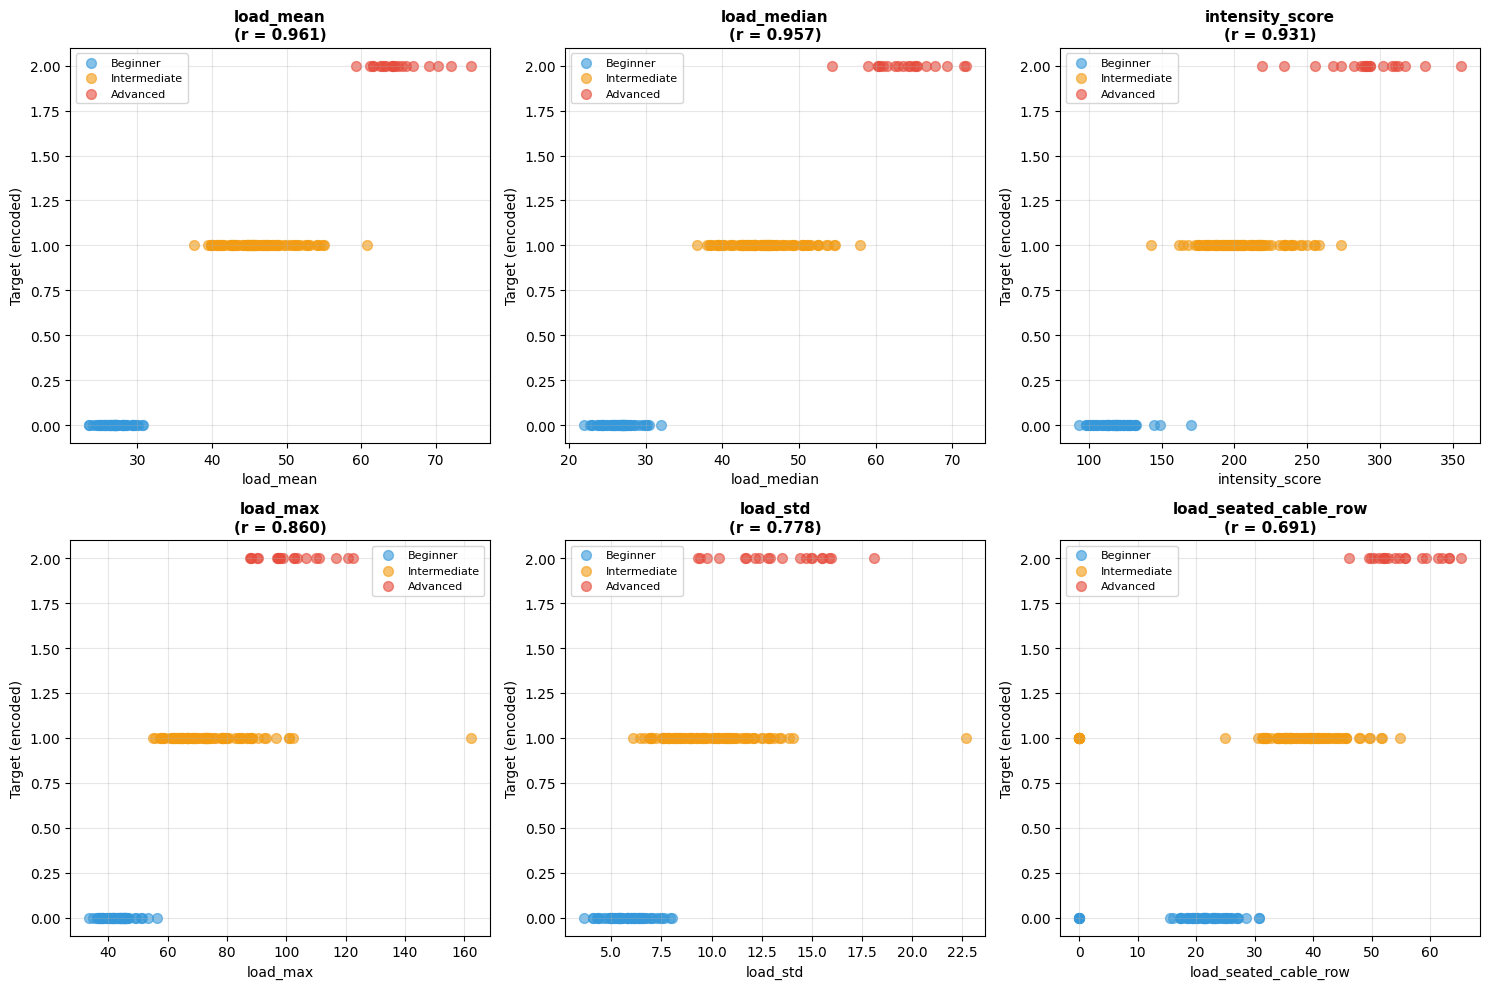

In [14]:
print("="*80)
print("SCATTER PLOT FEATURE VS TARGET")
print("="*80)

# Top 6 feature per scatter plot
top_6_features = correlations_full.head(6).index.tolist()

print(f"\nTop 6 feature per scatter plot:")
for i, feat in enumerate(top_6_features, 1):
    print(f"  {i}. {feat}: r = {correlations_full[feat]:.3f}")

# Scatter plot matrix
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

colors = {'Beginner': '#3498db', 'Intermediate': '#f39c12', 'Advanced': '#e74c3c'}

for idx, feature in enumerate(top_6_features):
    if feature in dataset_final.columns:
        for level in ['Beginner', 'Intermediate', 'Advanced']:
            subset = dataset_final[dataset_final['experience_label'] == level]
            axes[idx].scatter(
                subset[feature],
                subset['target_encoded'],
                alpha=0.6,
                s=50,
                label=level,
                color=colors[level]
            )

        axes[idx].set_xlabel(feature, fontsize=10)
        axes[idx].set_ylabel('Target (encoded)', fontsize=10)
        axes[idx].set_title(f'{feature}\n(r = {correlations_full[feature]:.3f})',
                           fontsize=11, fontweight='bold')
        axes[idx].legend(fontsize=8)
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('scatter_top6_features.png', dpi=150, bbox_inches='tight')
print("\nSalvato: scatter_top6_features.png")
plt.show()


---

# SEZIONE 11e: Feature Importance Preliminare

Analisi preliminare dell'importanza delle feature tramite Random Forest.

**Obiettivo:**  
Identificare le feature più predittive prima della fase di modeling completa.


---

**Nota Metodologica:**  
Questo è un quick test preliminare per validare il potere predittivo delle feature.
L'accuracy al 100% su 24 campioni test è incoraggiante ma va verificata con:
- Cross-validation stratificata (k-fold)
- Test su dataset holdout separato
- Analisi learning curves (overfitting?)

Il modeling completo sarà fatto in un notebook separato.

---

FEATURE IMPORTANCE PRELIMINARE

Feature totali: 47
Campioni: 174

Random Forest Quick Test:
  Train Accuracy: 1.000
  Test Accuracy: 0.971

Top 20 Feature Importance:
               feature  importance
           load_median    0.164149
              load_max    0.117370
       intensity_score    0.102361
             load_mean    0.101127
            load_squat    0.096295
 load_seated_cable_row    0.074086
     load_lat_pulldown    0.071155
      load_barbell_row    0.057790
 load_incline_db_press    0.027769
      load_bench_press    0.027075
              load_std    0.027041
        load_leg_press    0.021666
        load_cable_fly    0.021626
         load_leg_curl    0.018502
            load_plank    0.012285
    load_lateral_raise    0.012071
load_romanian_deadlift    0.009440
               rpe_std    0.007845
                cv_rpe    0.004705
   load_volume_product    0.002856

Salvato: feature_importance_rf.png


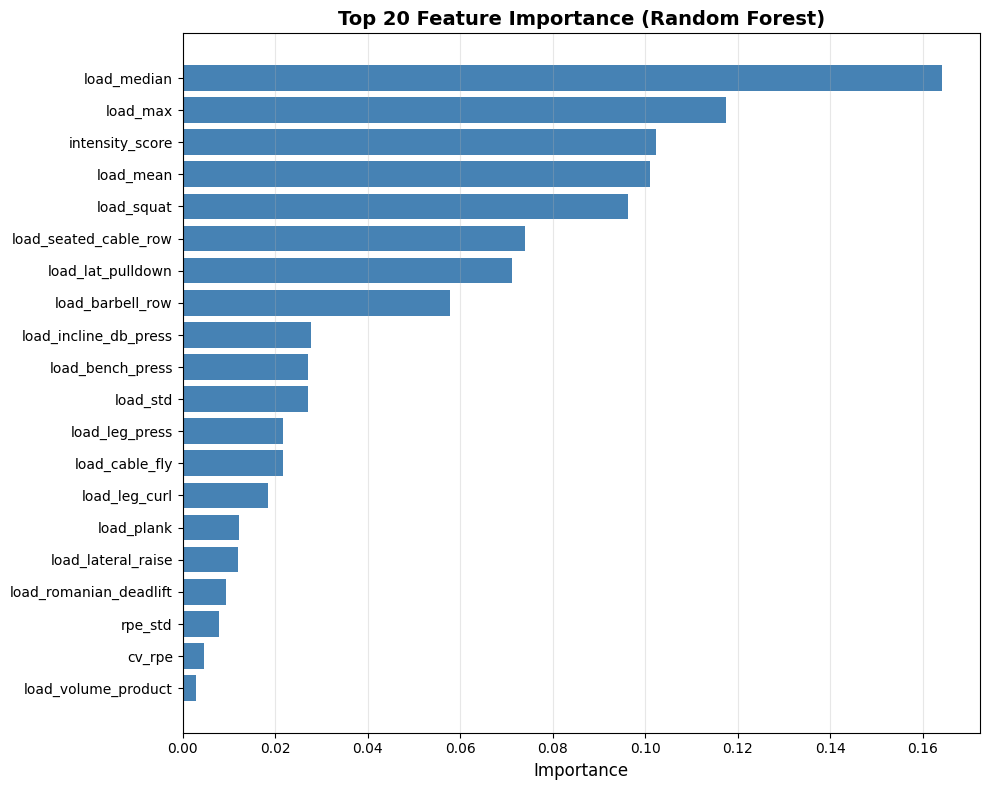

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

print("="*80)
print("FEATURE IMPORTANCE PRELIMINARE")
print("="*80)

# Prepara dati
X = dataset_final.select_dtypes(include=[np.number]).drop(
    columns=['userid', 'target_encoded'], errors='ignore'
)
y = dataset_final['target_encoded']

print(f"\nFeature totali: {X.shape[1]}")
print(f"Campioni: {X.shape[0]}")

# Quick Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                      random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print(f"\nRandom Forest Quick Test:")
print(f"  Train Accuracy: {train_score:.3f}")
print(f"  Test Accuracy: {test_score:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 20 Feature Importance:")
print(feature_importance.head(20).to_string(index=False))

# Plot importance
plt.figure(figsize=(10, 8))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'], color='steelblue')
plt.yticks(range(len(top_20)), top_20['feature'], fontsize=10)
plt.xlabel('Importance', fontsize=12)
plt.title('Top 20 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance_rf.png', dpi=150, bbox_inches='tight')
print("\nSalvato: feature_importance_rf.png")
plt.show()


---

# SEZIONE 11f: Summary Insights EDA

Riepilogo dei principali insight emersi dall'analisi esplorativa delle feature.

---


In [16]:
print("="*80)
print("SUMMARY INSIGHTS EDA FEATURE")
print("="*80)

print("\n1. FEATURE PIU' CORRELATE CON TARGET (Top 10):")
print("-" * 80)
print(correlations_full.head(10).to_string())

print("\n2. FEATURE MENO CORRELATE CON TARGET (Bottom 10):")
print("-" * 80)
print(correlations_full.tail(10).to_string())

print("\n3. RACCOMANDAZIONI PER FEATURE SELECTION:")
print("-" * 80)
print("  - Mantenere feature con |r| > 0.3 (correlazione moderata)")
print(f"  - Numero feature con |r| > 0.3: {(correlations_full.abs() > 0.3).sum()}")
print(f"  - Numero feature con |r| > 0.5: {(correlations_full.abs() > 0.5).sum()}")
print("  - Rimuovere coppie con |r| > 0.8 (multicollinearità)")
print("  - Verificare feature importance da Random Forest")

print("\n4. PROSSIMI STEP:")
print("-" * 80)
print("  1. Feature Selection (RFE, SHAP, permutation importance)")
print("  2. Scaling/Normalization")
print("  3. Modeling con cross-validation")
print("  4. Hyperparameter tuning")
print("  5. Interpretability analysis")

print("\n" + "="*80)
print("EDA FEATURE COMPLETATA")
print("="*80)


SUMMARY INSIGHTS EDA FEATURE

1. FEATURE PIU' CORRELATE CON TARGET (Top 10):
--------------------------------------------------------------------------------
load_mean                0.960636
load_median              0.956619
intensity_score          0.931337
load_max                 0.859900
load_std                 0.777609
load_seated_cable_row    0.691103
load_lat_pulldown        0.621724
load_incline_db_press    0.591479
load_squat               0.577606
rpe_std                 -0.575713

2. FEATURE MENO CORRELATE CON TARGET (Bottom 10):
--------------------------------------------------------------------------------
rpe_mean              0.087845
total_workouts        0.084284
freq_gap             -0.080216
has_compound          0.075206
volume_per_workout    0.054556
unique_exercises      0.051222
cv_reps               0.049479
relative_intensity    0.043050
load_range_pct       -0.037363
observation_days      0.001508

3. RACCOMANDAZIONI PER FEATURE SELECTION:
-----------------

---

# SEZIONE 11g: Feature Selection Automatica

Rimozione feature ridondanti e poco predittive per ottimizzare il dataset finale.

**Criteri di selezione:**
1. **Rimozione multicollinearità:** Elimina feature con |r| > 0.85 (mantieni quella più correlata con target)
2. **Soglia correlazione:** Mantieni solo feature con |r| > 0.15 vs target
3. **Variance threshold:** Rimuovi feature con varianza quasi zero

**Obiettivo:**  
Ridurre da 47 feature a ~20-30 feature ottimali per evitare overfitting e migliorare interpretabilità.

---


FEATURE SELECTION AUTOMATICA

STATUS INIZIALE:
  Feature totali: 47
  Campioni: 174

STEP 1: RIMOZIONE MULTICOLLINEARITA' (|r| > 0.85)

Coppie con |r| > 0.85 trovate: 31
  - total_sets (r=0.115) <-> total_workouts (r=0.084) | Rimuovo: total_workouts
  - observation_days (r=0.002) <-> total_workouts (r=0.084) | Rimuovo: observation_days
  - observation_days (r=0.002) <-> total_sets (r=0.115) | Rimuovo: observation_days
  - observed_freq_weekly (r=0.213) <-> weeklyfreq_declared (r=0.114) | Rimuovo: weeklyfreq_declared
  - load_max (r=0.860) <-> load_mean (r=0.961) | Rimuovo: load_max
  - load_std (r=0.778) <-> load_mean (r=0.961) | Rimuovo: load_std
  - load_std (r=0.778) <-> load_max (r=0.860) | Rimuovo: load_std
  - load_median (r=0.957) <-> load_mean (r=0.961) | Rimuovo: load_median
  - load_median (r=0.957) <-> load_max (r=0.860) | Rimuovo: load_max
  - reps_total (r=0.106) <-> total_workouts (r=0.084) | Rimuovo: total_workouts
  - reps_total (r=0.106) <-> total_sets (r=0.115) | Rimu

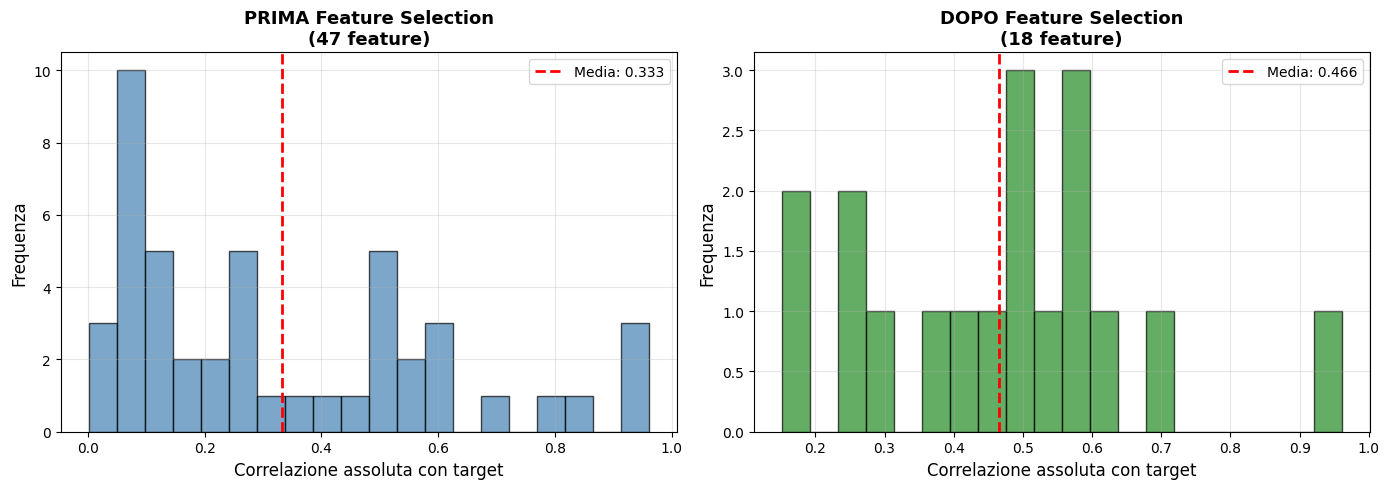


SALVATAGGIO DATASET FINALE

✓ Dataset con feature selezionate: dataset_engineered_SELECTED.csv
  - Righe: 174
  - Colonne: 21
  - Feature: 18

✓ Dataset solo feature selezionate: dataset_features_SELECTED.csv
✓ Lista feature selezionate: feature_names_SELECTED.txt

FEATURE SELECTION COMPLETATA

File pronti per il MODELING:
  1. dataset_engineered_SELECTED.csv (userid + features + target)
  2. dataset_features_SELECTED.csv (solo features + target)
  3. feature_names_SELECTED.txt (lista feature)

Prossimo step: MODELING con cross-validation


In [19]:
print("="*80)
print("FEATURE SELECTION AUTOMATICA")
print("="*80)

# Dataset iniziale
X_all = dataset_final.select_dtypes(include=[np.number]).drop(
    columns=['userid', 'target_encoded'], errors='ignore'
)
y = dataset_final['target_encoded']

print(f"\nSTATUS INIZIALE:")
print(f"  Feature totali: {X_all.shape[1]}")
print(f"  Campioni: {X_all.shape[0]}")

# ============================================================================
# STEP 1: RIMOZIONE MULTICOLLINEARITA'
# ============================================================================
print("\n" + "="*80)
print("STEP 1: RIMOZIONE MULTICOLLINEARITA' (|r| > 0.85)")
print("="*80)

corr_matrix = X_all.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Trova coppie con alta correlazione
high_corr_pairs = []
for column in upper_tri.columns:
    high_corr = upper_tri[column][upper_tri[column] > 0.85]
    if len(high_corr) > 0:
        for idx in high_corr.index:
            high_corr_pairs.append((column, idx, upper_tri.loc[idx, column]))

print(f"\nCoppie con |r| > 0.85 trovate: {len(high_corr_pairs)}")

# Per ogni coppia, rimuovi quella meno correlata con target
features_to_drop_multicol = set()
target_corr = X_all.corrwith(y).abs()

for feat1, feat2, corr_val in high_corr_pairs:
    corr1 = target_corr[feat1]
    corr2 = target_corr[feat2]

    # Rimuovi quella con correlazione minore verso target
    to_drop = feat1 if corr1 < corr2 else feat2
    features_to_drop_multicol.add(to_drop)
    print(f"  - {feat1} (r={corr1:.3f}) <-> {feat2} (r={corr2:.3f}) | Rimuovo: {to_drop}")

print(f"\nFeature da rimuovere per multicollinearità: {len(features_to_drop_multicol)}")
print(f"Lista: {sorted(features_to_drop_multicol)}")

X_step1 = X_all.drop(columns=list(features_to_drop_multicol))
print(f"\nFeature rimanenti dopo step 1: {X_step1.shape[1]}")

# ============================================================================
# STEP 2: SOGLIA CORRELAZIONE CON TARGET
# ============================================================================
print("\n" + "="*80)
print("STEP 2: SOGLIA CORRELAZIONE CON TARGET (|r| > 0.15)")
print("="*80)

target_corr_step1 = X_step1.corrwith(y).abs()
low_corr_features = target_corr_step1[target_corr_step1 <= 0.15].index.tolist()

print(f"\nFeature con |r| <= 0.15 (poco predittive): {len(low_corr_features)}")
for feat in low_corr_features:
    print(f"  - {feat}: r = {target_corr_step1[feat]:.3f}")

X_step2 = X_step1.drop(columns=low_corr_features)
print(f"\nFeature rimanenti dopo step 2: {X_step2.shape[1]}")

# ============================================================================
# STEP 3: VARIANCE THRESHOLD
# ============================================================================
print("\n" + "="*80)
print("STEP 3: VARIANCE THRESHOLD (rimuovi feature con variance < 0.01)")
print("="*80)

from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
selector.fit(X_step2)

low_var_features = X_step2.columns[~selector.get_support()].tolist()
print(f"\nFeature con variance < 0.01: {len(low_var_features)}")
if low_var_features:
    for feat in low_var_features:
        print(f"  - {feat}: var = {X_step2[feat].var():.4f}")
    X_final_selected = X_step2.drop(columns=low_var_features)
else:
    print("  Nessuna feature trovata (tutte hanno variance sufficiente)")
    X_final_selected = X_step2

# ============================================================================
# RISULTATO FINALE
# ============================================================================
print("\n" + "="*80)
print("RISULTATO FEATURE SELECTION")
print("="*80)

print(f"\nFeature INIZIALI: {X_all.shape[1]}")
print(f"Feature FINALI:   {X_final_selected.shape[1]}")
print(f"Riduzione:        {X_all.shape[1] - X_final_selected.shape[1]} feature (-{(1 - X_final_selected.shape[1]/X_all.shape[1])*100:.1f}%)")

print(f"\n{'='*80}")
print("FEATURE SELEZIONATE (ordinate per correlazione con target):")
print(f"{'='*80}")

final_corr = X_final_selected.corrwith(y).abs().sort_values(ascending=False)
for i, (feat, corr_val) in enumerate(final_corr.items(), 1):
    print(f"{i:2d}. {feat:30s} | r = {corr_val:.3f}")

# ============================================================================
# CONFRONTO PRIMA/DOPO
# ============================================================================
print("\n" + "="*80)
print("CONFRONTO DISTRIBUZIONE CORRELAZIONI")
print("="*80)

corr_before = X_all.corrwith(y).abs()
corr_after = X_final_selected.corrwith(y).abs()

print(f"\nPRIMA:")
print(f"  - Media correlazione: {corr_before.mean():.3f}")
print(f"  - Mediana correlazione: {corr_before.median():.3f}")
print(f"  - Feature con |r| > 0.3: {(corr_before > 0.3).sum()}")
print(f"  - Feature con |r| > 0.5: {(corr_before > 0.5).sum()}")

print(f"\nDOPO:")
print(f"  - Media correlazione: {corr_after.mean():.3f}")
print(f"  - Mediana correlazione: {corr_after.median():.3f}")
print(f"  - Feature con |r| > 0.3: {(corr_after > 0.3).sum()}")
print(f"  - Feature con |r| > 0.5: {(corr_after > 0.5).sum()}")

print(f"\nMiglioramento media correlazione: +{(corr_after.mean() - corr_before.mean()):.3f}")

# Visualizzazione confronto
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prima
axes[0].hist(corr_before, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(corr_before.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {corr_before.mean():.3f}')
axes[0].set_xlabel('Correlazione assoluta con target', fontsize=12)
axes[0].set_ylabel('Frequenza', fontsize=12)
axes[0].set_title(f'PRIMA Feature Selection\n({X_all.shape[1]} feature)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Dopo
axes[1].hist(corr_after, bins=20, color='forestgreen', alpha=0.7, edgecolor='black')
axes[1].axvline(corr_after.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {corr_after.mean():.3f}')
axes[1].set_xlabel('Correlazione assoluta con target', fontsize=12)
axes[1].set_ylabel('Frequenza', fontsize=12)
axes[1].set_title(f'DOPO Feature Selection\n({X_final_selected.shape[1]} feature)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('feature_selection_comparison.png', dpi=150, bbox_inches='tight')
print(f"\nSalvato: feature_selection_comparison.png")
plt.show()

# ============================================================================
# SALVA DATASET CON FEATURE SELEZIONATE
# ============================================================================
print("\n" + "="*80)
print("SALVATAGGIO DATASET FINALE")
print("="*80)

# Ricostruisci dataset finale con feature selezionate
dataset_final_selected = dataset_final[['userid', 'experience_label']].copy()
for col in X_final_selected.columns:
    dataset_final_selected[col] = dataset_final[col]
dataset_final_selected['target_encoded'] = dataset_final['target_encoded']

# Salva
output_file_selected = 'dataset_engineered_SELECTED.csv'
# dataset_final_selected.to_csv(output_file_selected, index=False)
print(f"\n✓ Dataset con feature selezionate: {output_file_selected}")
print(f"  - Righe: {len(dataset_final_selected)}")
print(f"  - Colonne: {len(dataset_final_selected.columns)}")
print(f"  - Feature: {X_final_selected.shape[1]}")

# Salva anche solo feature + target
features_selected_only = X_final_selected.copy()
features_selected_only['target_encoded'] = y
output_file_features_selected = 'dataset_features_SELECTED.csv'
# features_selected_only.to_csv(output_file_features_selected, index=False)
print(f"\n✓ Dataset solo feature selezionate: {output_file_features_selected}")

# Salva lista feature selezionate
# with open('feature_names_SELECTED.txt', 'w') as f:
#f.write('\n'.join(X_final_selected.columns.tolist()))
print(f"✓ Lista feature selezionate: feature_names_SELECTED.txt")

print("\n" + "="*80)
print("FEATURE SELECTION COMPLETATA")
print("="*80)
print("\nFile pronti per il MODELING:")
print("  1. dataset_engineered_SELECTED.csv (userid + features + target)")
print("  2. dataset_features_SELECTED.csv (solo features + target)")
print("  3. feature_names_SELECTED.txt (lista feature)")
print("\nProssimo step: MODELING con cross-validation")
print("="*80)


---

# SEZIONE 12: Salvataggio Dataset Processato

Esportazione del dataset finale in formato CSV.

**File generati:**

1. **`dataset_engineered_full.csv`**  
   Dataset completo con tutte le colonne (userid, experience_label, target_encoded, features)

2. **`dataset_engineered_features_only.csv`**  
   Solo feature numeriche + target_encoded (pronto per modeling)

3. **`feature_names.txt`**  
   Lista nomi feature per reference

**Uso successivo:**
- Modeling (Random Forest, XGBoost, SVM)
- Feature Selection
- Cross-validation
- Hyperparameter tuning

---

In [22]:
print("="*80)
print("SALVATAGGIO DATASET FINALE")
print("="*80)

# ============================================================================
# Crea STATUS_final.csv con SOLO le feature selezionate
# ============================================================================

# Ordine colonne: userid → target → feature selezionate
final_columns = ['userid', 'experience_label', 'target_encoded'] + list(X_final_selected.columns)

# Crea dataset finale
STATUS_final = dataset_final[final_columns].copy()

# Salva UNICO CSV
output_file = 'STATUS_final.csv'
STATUS_final.to_csv(output_file, index=False)

print(f"\nDataset finale salvato: {output_file}")
print(f"\nCONTENUTO:")
print("-"*80)
print(f"   Righe (utenti):        {len(STATUS_final)}")
print(f"   Colonne totali:        {len(STATUS_final.columns)}")
print(f"   - userid:              1")
print(f"   - experience_label:    1")
print(f"   - target_encoded:      1")
print(f"   - feature selezionate: {len(X_final_selected.columns)}")

print(f"\n📋 FEATURE SELEZIONATE ({len(X_final_selected.columns)}):")
print("-"*80)
for i, col in enumerate(X_final_selected.columns, 1):
    corr_val = X_final_selected[col].corr(STATUS_final['target_encoded'])
    print(f"   {i:2d}. {col:35s} (r={corr_val:+.3f})")

print(f"\nDISTRIBUZIONE TARGET:")
print("-"*80)
target_dist = STATUS_final['experience_label'].value_counts().sort_index()
for level, count in target_dist.items():
    pct = count / len(STATUS_final) * 100
    print(f"   {level:12s}: {count:3d} utenti ({pct:.1f}%)")

print(f"\n" + "="*80)
print("FEATURE ENGINEERING COMPLETATO")
print("="*80)
print(f"\nPROSSIMO STEP:")
print(f"   Aprire notebook: STATUS_Modeling_Base.ipynb")
print(f"   Caricare file:   {output_file}")
print(f"\nFILE OUTPUT UNICO: {output_file}")
print("   - Contiene SOLO le feature selezionate dopo feature selection")
print("   - Pronto per modeling senza ulteriori preprocessing")
print("="*80)


SALVATAGGIO DATASET FINALE

Dataset finale salvato: STATUS_final.csv

CONTENUTO:
--------------------------------------------------------------------------------
   Righe (utenti):        174
   Colonne totali:        21
   - userid:              1
   - experience_label:    1
   - target_encoded:      1
   - feature selezionate: 18

📋 FEATURE SELEZIONATE (18):
--------------------------------------------------------------------------------
    1. load_mean                           (r=+0.961)
    2. reps_mean                           (r=-0.152)
    3. rpe_max                             (r=-0.173)
    4. load_volume_product                 (r=+0.373)
    5. skip_rate                           (r=-0.271)
    6. load_barbell_row                    (r=+0.493)
    7. load_bench_press                    (r=+0.483)
    8. load_cable_fly                      (r=+0.571)
    9. load_incline_db_press               (r=+0.591)
   10. load_lat_pulldown                   (r=+0.622)
   11. load_late